<h1> Model with transfer learning </h1>

Use pretrained model in keras for the price task.

Contains the loading and preprocessing of the images, the construction of the model architecture and the training

In [ ]:
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import csv
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
#mount the data from Google Drive in Google Colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Test to see if I can access the files from Google Drive

In [ ]:
#load the data from the csv metadata file

def load_csv_as_list(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8-sig') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            data.append(row)
    return data

data_list = load_csv_as_list("/content/drive/My Drive/dataset_AA2/metadata_v2.csv")

In [ ]:
dataset = pd.read_csv('/content/drive/My Drive/dataset_AA2/metadata_v2.csv')

In [ ]:
print(dataset.head)

<bound method NDFrame.head of                                              Image Name  Price  \
0     1012570_ss_870485a0d44dbe753c8687e021b6add1b0b...   1950   
1     1012570_ss_8bfe060a5bfb9ddcc46312672c3cc3bab15...   1950   
2     1012570_ss_8cafeb71a81cbe885069aeab504760420a3...   1950   
3     1012570_ss_981efe598ec5e2a12127850d5c480610a30...   1950   
4     1012570_ss_9f5adde630a5c44b16e2d2a51c98652cdb0...   1950   
...                                                 ...    ...   
1728  1147130_ss_fd7c63a2ef5e00352a0dcfa8e9515d53d35...    499   
1729  1147330_ss_39f63ef7eba2f495706425460ea547d15ff...   1999   
1730  1147330_ss_3f4aebc6e21952622167f780b47f6c88ecf...   1999   
1731  1147330_ss_4d092f15b1163fd9ec6295d9b3db4577f25...   1999   
1732  1147330_ss_732f1c0b4c8b4c5190140e0262d2cab3a89...   1999   

                          Game Name  
0                  Knuckle Sandwich  
1                  Knuckle Sandwich  
2                  Knuckle Sandwich  
3                  Knuckl

Start Modelling

Based on: https://keras.io/guides/transfer_learning/

Setup the data

In [ ]:
input_size = (299,299)
INPUT_SHAPE = (299,299,3)
batch_size = 32

In [ ]:
# Create ImageDataGenerator instances for training and validation data
train_datagen = ImageDataGenerator(preprocessing_function=keras.applications.xception.preprocess_input)
validation_datagen = ImageDataGenerator(preprocessing_function=keras.applications.xception.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=keras.applications.xception.preprocess_input)

# Create image generators for training and validation data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=dataset,
    directory="/content/drive/My Drive/dataset_AA2/images-processed/train",
    x_col="Image Name",
    y_col="Price",
    target_size=input_size,
    batch_size=batch_size,
    class_mode='raw',  # Use 'raw' for regression tasks
    shuffle=True
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=dataset,
    directory="/content/drive/My Drive/dataset_AA2/images-processed/validation",
    x_col="Image Name",
    y_col="Price",
    target_size=input_size,
    batch_size=batch_size,
    class_mode='raw',  # Use 'raw' for regression tasks
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=dataset,
    directory="/content/drive/My Drive/dataset_AA2/images-processed/test",
    x_col="Image Name",
    y_col="Price",
    target_size=input_size,
    batch_size=batch_size,
    class_mode='raw',  # Use 'raw' for regression tasks
    shuffle=False
)

Found 1492 validated image filenames.
Found 116 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 241 invalid image filename(s) in x_col="Image Name". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1617 invalid image filename(s) in x_col="Image Name". These filename(s) will be ignored.
  warnings.warn(


Found 125 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1608 invalid image filename(s) in x_col="Image Name". These filename(s) will be ignored.
  warnings.warn(


Define the model

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape= INPUT_SHAPE,
    include_top=False)  # Do not include the ImageNet classifier at the top.

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
#freeze the model
base_model.trainable = False

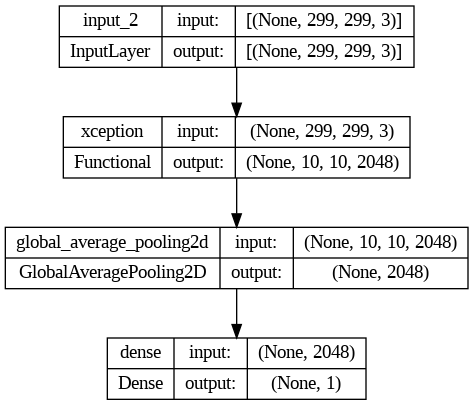

In [ ]:
#add a model on top of the base model

inputs = keras.Input(shape = INPUT_SHAPE)
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

keras.utils.plot_model(model, show_shapes=True)
#keras.utils.plot_model(base_model, show_shapes=True)

In [ ]:
#train on the new model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss = keras.losses.MeanSquaredError(),
              metrics = [keras.losses.MeanSquaredError()])
model.fit(train_generator, epochs=150, validation_data= validation_generator) #, callbacks=...

Epoch 1/150
47/47 [==============================] - 829s 17s/step - loss: 3828575.7500 - mean_squared_error: 3827909.7500 - val_loss: 4607527.5000 - val_mean_squared_error: 4177383.5000
Epoch 2/150
47/47 [==============================] - 19s 396ms/step - loss: 3416838.2500 - mean_squared_error: 3409315.7500 - val_loss: 4220683.0000 - val_mean_squared_error: 3831995.5000
Epoch 3/150
47/47 [==============================] - 18s 389ms/step - loss: 3054108.7500 - mean_squared_error: 3045384.7500 - val_loss: 3883327.5000 - val_mean_squared_error: 3534322.0000
Epoch 4/150
47/47 [==============================] - 19s 399ms/step - loss: 2744199.7500 - mean_squared_error: 2752905.2500 - val_loss: 3586169.5000 - val_mean_squared_error: 3275634.7500
Epoch 5/150
47/47 [==============================] - 19s 402ms/step - loss: 2476091.2500 - mean_squared_error: 2484666.5000 - val_loss: 3333675.5000 - val_mean_squared_error: 3059185.0000
Epoch 6/150
47/47 [==============================] - 19s 393m

In [ ]:
#save the final model
model.save("/content/drive/My Drive/dataset_AA2/models/model_1_Xception_150epo_1500data_LR_001.keras")